## Setup

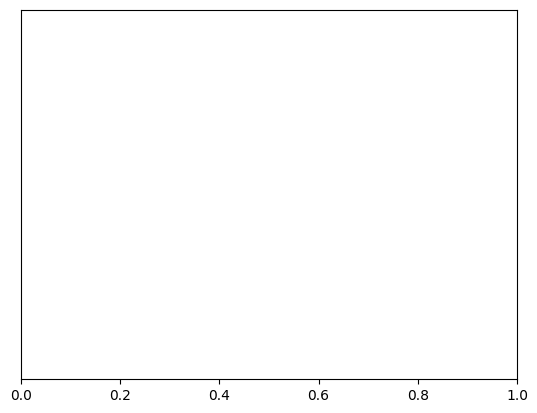

In [25]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
plt.tick_params(left=False, labelleft=False) #remove ticks

import numpy as np
import csv
import math
import random
from BSE import Trader_PRZI
from BSE import market_session
import pandas as pd

# reload imports
%reload_ext autoreload
%autoreload 2

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

## Experiment 1: Changing the values of k and F homogenously

### Set up for static market session

In [26]:
n_days = 10
n_hours = 24*n_days
start_time = 0.0
end_time = 60*60*n_hours
duration = end_time - start_time

supRange = (60, 140)
demRange = (60, 140)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supRange], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demRange], 'stepmode': 'fixed'}]

order_interval = 5
order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

trail_id = 'change_k_outputs/change_K'
fname = trail_id + '_balances.csv'
tdump = open(fname, 'w')

# 4 - 11
k_min = 4
k_max = 12

### Calculating PPS (ignore)

In [ ]:


df = pd.read_csv(trial_id + '_blotters.csv', names=['Traders', 'Trade', 'Time', 'Trade_price', 'id', 'id2','Quantity'])
df['Trade_price'] = df['Trade_price'].fillna(0)

b_sum = 0
s_sum = 0
num_trades = len(df.index)//2

for i in range(num_trades):
    price = df.loc[i]['Trade_price']
    b_sum += abs(140-price)
    s_sum += abs(price-60)
    
print(s_sum)
print(b_sum)

print(s_sum/720)
print(b_sum/720)

### Keeping F = 0.8 and finding best k value

In [ ]:


# for k in range(k_min,k_max):
#     buyers_spec = [('PRDE', 30, {'k': k, 'f_value':0.8, 's_min': -1.0, 's_max': +1.0})] 
#     sellers_spec = buyers_spec
#     traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#     trial = 1
#     while trial <= 1:
#         trial_id = trail_id+'_%d' % (k)
#         market_session(trial_id, start_time, end_time, traders_spec,order_sched, tdump, False, True)
#         tdump.flush()
#         trial+=1
    
# tdump.close()    


Read the pps values from all the strats.csv files for all values of k used and plot the moving averages for each

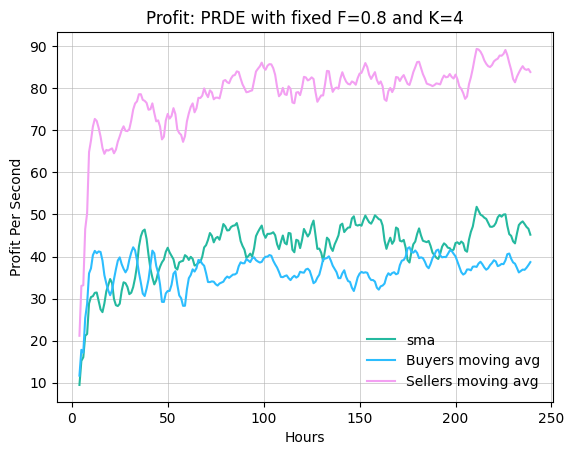

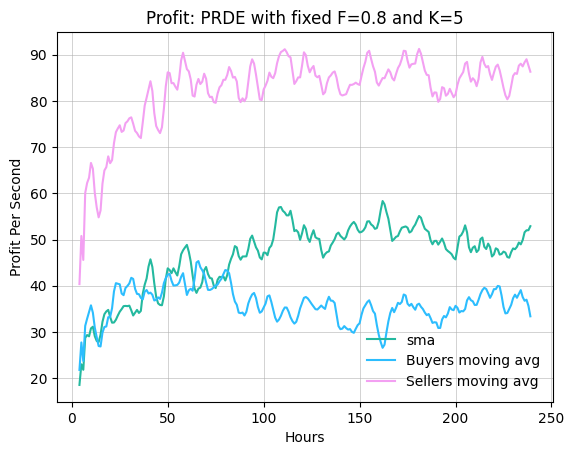

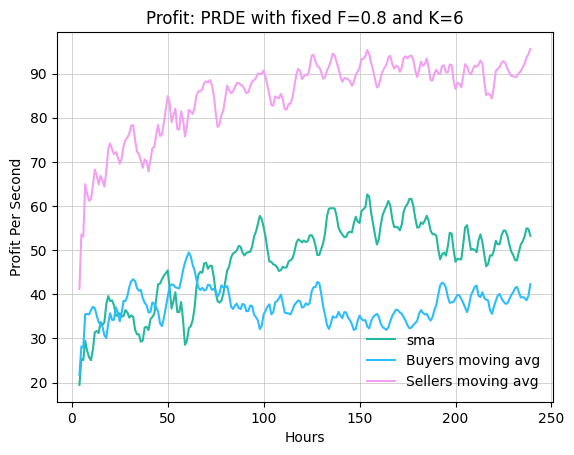

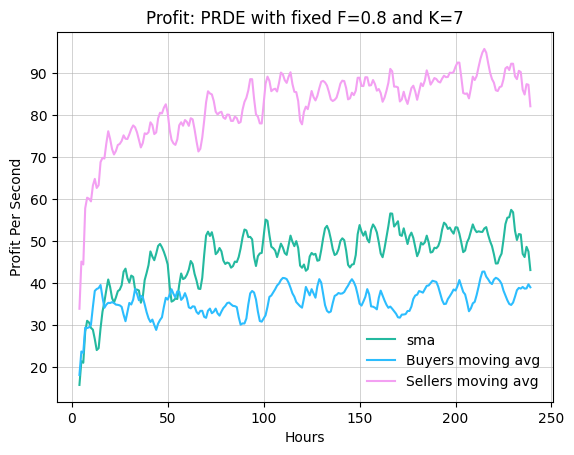

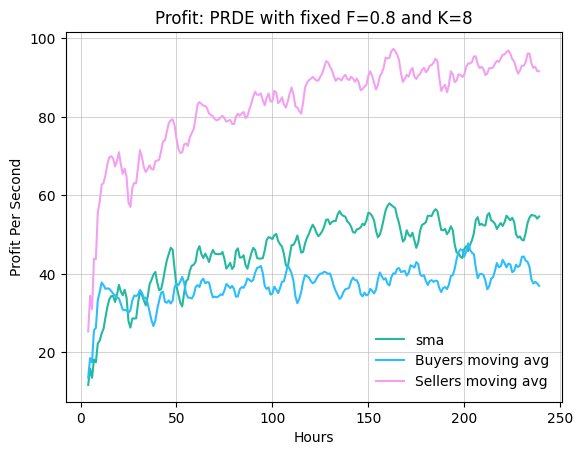

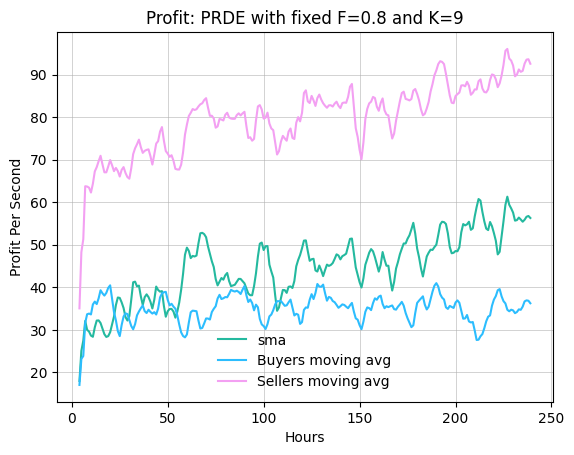

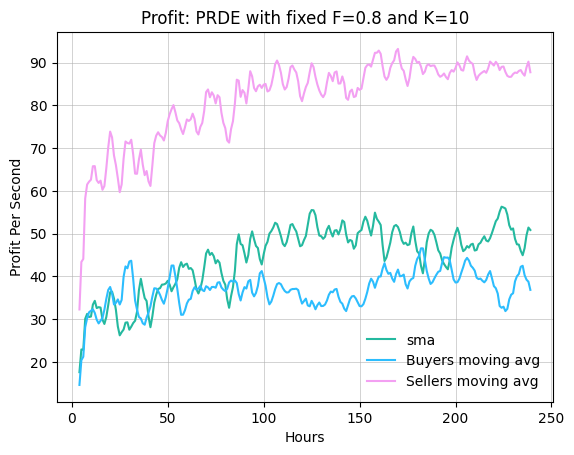

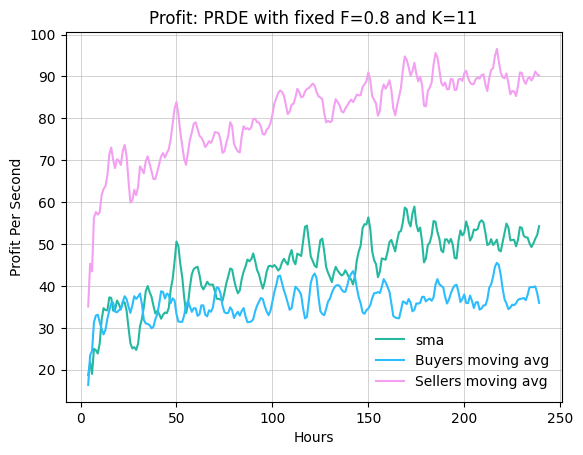

In [50]:
import pandas as pd 
from matplotlib import pyplot as plt
CB91_Blue = '#2CBDFE'
CB91_Green = '#24B99F'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
CB91_Brown= '#98501C'
CB91_Red = '#D43334'

def plot_csv_changes_k (filename, k_value):
    df = pd.read_csv( filename,header=None,)
    new_df_buyer = pd.DataFrame()
    new_df_seller = pd.DataFrame()

    
    for row in range(0,len(df.index)):
        b_sum = 0
        s_sum = 0
        for col in range (8, 219 ,7):
            b_sum +=df.loc[row][col]
        new_df_buyer.loc[len(new_df_buyer.index), 0] = b_sum

        for col in range (225, 428,7):
            s_sum +=df.loc[row][col]
        new_df_seller.loc[len(new_df_seller.index), 0] = s_sum
      
    buyers_sma = new_df_buyer.loc[:,0].rolling(5).mean()
    sellers_sma = new_df_seller.loc[:,0].rolling(5).mean()
    total_sma =  buyers_sma + sellers_sma
    
    t_period = list(range(0,len(buyers_sma.index)))
    
    plt.plot(t_period, buyers_sma, color=CB91_Green, label='sma') 
    plt.plot(t_period, sellers_sma, color=CB91_Blue, label='Buyers moving avg') 
    plt.plot(t_period, total_sma, color=CB91_Pink, label='Sellers moving avg') 
    plt.xlabel("Hours")
    plt.ylabel("Profit Per Second")
    plt.title("Profit: PRDE with fixed F=0.8 and K="+str(k_value))
    plt.legend(best, frameon=False)
    plt.grid(linewidth=0.4)
    
    # plt.savefig(f'figures/Change_K_{k_value}_0.8_F.png')
    plt.show()
    return total_sma
    

for k in range(k_min, k_max):
    plot_csv_changes_k(trail_id + '_' + str(k) + '_strats.csv', k)
    

Process the results and determine best k value

In [ ]:


# plt.xlabel("Hours")
# plt.ylabel("Profit Per Second")
# plt.title("Profit: PRDE with fixed F=0.8 and K=(4-11)")

# def process_multiple_ppc(hours):
#     colors = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet, CB91_Brown, CB91_Red]
    
#     all_k_t_mov_avg = []
#     i=0
#     for k in range(k_min, k_max):
#         k_t_mov_avg = plot_csv_changes_k(trail_id + '_' + str(k) + '_strats.csv', k)
#         all_k_t_mov_avg.append(k_t_mov_avg)
        
#         t_period = list(range(0,hours))
#         plt.plot(t_period, k_t_mov_avg, color=colors[i],linewidth = '0.7', label=f'k = {k}') 
#         print(".")
#         i+=1
#     plt.legend(frameon=False)
#     plt.grid(linewidth=0.4)
#     plt.savefig(f'figures/Change_K_0.8_F_TOTAL.png')
#     plt.show()
#     return(all_k_t_mov_avg)

# all_k_t_mov_avg = process_multiple_ppc(n_hours)

.

In [ ]:
# all_means = []
# for i in range(len(all_k_t_mov_avg)):
#     mean_i = np.mean(all_k_t_mov_avg[i])
#     all_means.append(mean_i)

# # Best k for f=0.8 -----------------------
# maxMean = max(all_means)
# maxK = np.argmax(all_means) + 4

# print(f"Best_k overall: {maxK}")
# print(f"Mean: {maxMean}")

# # Top 4 performning k's for f=0.8 --------
# sorted(all_means, reverse=True)[:3]

# top4_means_and_k = sorted(((value, index) for index, value in enumerate(all_means)), reverse=True)[:4]
# top4_k = []
# for n in top4_means_and_k:
#     top4_k.append(n[1]+4)

# print("\nTop 4 performing k values:", top4_k)

### Change f=(0-2) for top 4 k values

### Changing both f values from 0-2 and k from 4-12

In [ ]:

# trail_id = 'trail'
# fname = trail_id + 'balances.csv'

# tdump = open(fname, 'w')

# min_n = 1

# # trialnumber = 1
# # trdr_1_n = min_n
# for k in range(4,13):
#     for f in np.arange(0.0,2.0,0.1):
#         buyers_spec = [('PRDE', 30, {'k': k, 'f_value':f, 's_min': -1.0, 's_max': +1.0})] 
#         sellers_spec = buyers_spec
#         traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#         trial = 1
#         while trial <= 1:
#             trial_id = '%02d_%02f' % (k, f)
#             market_session(trial_id, start_time, end_time, traders_spec,
#                            order_sched, tdump, False, True)
#             tdump.flush()
#             trial+=1

# tdump.close()

.

## Experiment 2: Changing the values of k and F hetrogenously

## Experiment 3: Dynamic Market